## The data represents credit card transactions that occurred over two days in September 2013 by European cardholders.

### All details of the cardholders have been anonymized via a principal component analysis (PCA) transform.

In [1]:
# load libraries
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.dummy import DummyClassifier

In [2]:
# define the dataset location
filename = 'creditcard.csv'
# load the csv file as a data frame
df = pd.read_csv(filename, header=None)

In [3]:
# summarize the shape of the dataset
print(df.shape)

(284807, 31)


In [4]:
# summarize the class distribution
target =  df.values[:, -1]
counter = Counter(target)
for k, v in counter.items():
    perc = v/len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, perc))

Class=0, Count=284315, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%


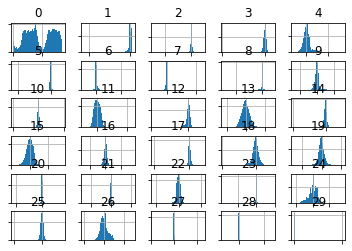

In [5]:
# drop the target variable
df_num = df.drop(30, axis=1)
# create a histogram plot of each numeric variable
ax = df_num.hist(bins=50)
# disable axis labels to avoid the clutter
for axis in ax.flatten():
	axis.set_xticklabels([])
	axis.set_yticklabels([])
# show the plot
plt.show()

###  We can see that the distribution of most of the PCA components is Gaussian, and many may be centered around zero, suggesting that the variables were standardized as part of the PCA transform.

In [6]:
# summarize the amount variable.
print(df_num[29].describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: 29, dtype: float64


## Model Test and Baseline Result

###### The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, at least compared to a single train-test split. We will use k=10, meaning each fold will contain about 284807/10 or 28,480 examples.

###### Stratified means that each fold will contain the same mixture of examples by class, that is about 99.8 percent to 0.2 percent normal and fraudulent transaction respectively. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use 3 repeats.

In [7]:
# split data into input and target elements
X, y = df.iloc[:, :-1].values , df.iloc[:, -1].values

In [8]:
# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
# calculate precision-recall curve
	p, r, _ = precision_recall_curve(y_true, probas_pred)
	# calculate area under curve
	return auc(r, p)

In [9]:
# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# define the model evaluation the metric
	metric = make_scorer(pr_auc, needs_proba=True)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
	return scores

In [10]:
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

(284807, 30) (284807,) Counter({0: 284315, 1: 492})


In [11]:
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean PR AUC: 0.501 (0.000)


## Evaluate Machine Learning Algorithms

In [12]:
#define models to test
def get_models():
	models, names = [], []
	# CART
	models.append(DecisionTreeClassifier())
	names.append('CART')
	# Bagging
	models.append(BaggingClassifier(n_estimators=100))
	names.append('BAG')
	# GB
	models.append(GradientBoostingClassifier(n_estimators=100))
	names.append('GB')
	# RF
	models.append(RandomForestClassifier(n_estimators=100))
	names.append('RF')
	# ET
	models.append(ExtraTreesClassifier(n_estimators=100))
	names.append('ET')
    # KNN
	steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
	models.append(Pipeline(steps=steps))
	names.append('KNN')
	return models, names


In [13]:
# define models
models, names = get_models()
results = []
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(X, y, models[i])
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>CART 0.756 (0.044)
>BAG 0.845 (0.049)
>GB 0.481 (0.206)
>RF 0.855 (0.048)
>ET 0.863 (0.044)
>KNN 0.869 (0.042)


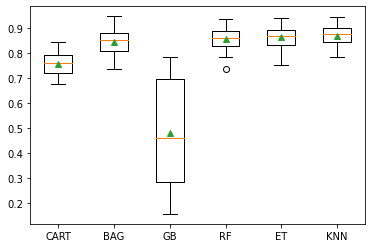

In [16]:
#plot the results
plt.boxplot(results, labels= names, showmeans= True)
plt.show()

In [17]:
models

[DecisionTreeClassifier(),
 BaggingClassifier(n_estimators=100),
 GradientBoostingClassifier(),
 RandomForestClassifier(),
 ExtraTreesClassifier(),
 Pipeline(steps=[('s', StandardScaler()), ('m', KNeighborsClassifier())])]

In [18]:
knnmodel = models[5]

In [19]:
#fit the model
knnmodel.fit(X,y)

Pipeline(steps=[('s', StandardScaler()), ('m', KNeighborsClassifier())])

In [20]:
# evaluate on some normal cases (known class 0)
print('Normal cases:')
data = [[0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,0.0907941719789316,-0.551599533260813,-0.617800855762348,-0.991389847235408,-0.311169353699879,1.46817697209427,-0.470400525259478,0.207971241929242,0.0257905801985591,0.403992960255733,0.251412098239705,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62],
	[0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69],
	[1,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,0.207642865216696,0.624501459424895,0.066083685268831,0.717292731410831,-0.165945922763554,2.34586494901581,-2.89008319444231,1.10996937869599,-0.121359313195888,-2.26185709530414,0.524979725224404,0.247998153469754,0.771679401917229,0.909412262347719,-0.689280956490685,-0.327641833735251,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66]]

Normal cases:


In [21]:
for row in data:
	# make prediction
	yhat = knnmodel.predict_proba([row])
	# get the probability for the positive class
	result = yhat[0][1]
	# summarize
	print('>Predicted=%.3f (expected 0)' % (result))

>Predicted=0.000 (expected 0)
>Predicted=0.000 (expected 0)
>Predicted=0.000 (expected 0)


In [22]:
# evaluate on some fraud cases (known class 1)
print('Fraud cases:')
data = [[406,-2.3122265423263,1.95199201064158,-1.60985073229769,3.9979055875468,-0.522187864667764,-1.42654531920595,-2.53738730624579,1.39165724829804,-2.77008927719433,-2.77227214465915,3.20203320709635,-2.89990738849473,-0.595221881324605,-4.28925378244217,0.389724120274487,-1.14074717980657,-2.83005567450437,-0.0168224681808257,0.416955705037907,0.126910559061474,0.517232370861764,-0.0350493686052974,-0.465211076182388,0.320198198514526,0.0445191674731724,0.177839798284401,0.261145002567677,-0.143275874698919,0],
	[7519,1.23423504613468,3.0197404207034,-4.30459688479665,4.73279513041887,3.62420083055386,-1.35774566315358,1.71344498787235,-0.496358487073991,-1.28285782036322,-2.44746925511151,2.10134386504854,-4.6096283906446,1.46437762476188,-6.07933719308005,-0.339237372732577,2.58185095378146,6.73938438478335,3.04249317830411,-2.72185312222835,0.00906083639534526,-0.37906830709218,-0.704181032215427,-0.656804756348389,-1.63265295692929,1.48890144838237,0.566797273468934,-0.0100162234965625,0.146792734916988,1],
	[7526,0.00843036489558254,4.13783683497998,-6.24069657194744,6.6757321631344,0.768307024571449,-3.35305954788994,-1.63173467271809,0.15461244822474,-2.79589246446281,-6.18789062970647,5.66439470857116,-9.85448482287037,-0.306166658250084,-10.6911962118171,-0.638498192673322,-2.04197379107768,-1.12905587703585,0.116452521226364,-1.93466573889727,0.488378221134715,0.36451420978479,-0.608057133838703,-0.539527941820093,0.128939982991813,1.48848121006868,0.50796267782385,0.735821636119662,0.513573740679437,1]]
for row in data:
	# make prediction
	yhat = knnmodel.predict_proba([row])
	# get the probability for the positive class
	result = yhat[0][1]
	# summarize
	print('>Predicted=%.3f (expected 1)' % (result))

Fraud cases:
>Predicted=1.000 (expected 1)
>Predicted=0.400 (expected 1)
>Predicted=1.000 (expected 1)


In [23]:
import joblib
joblib.dump(knnmodel, "creditfraudknn_model.pkl")

['creditfraudknn_model.pkl']

In [12]:
# define model
model = XGBClassifier()

In [13]:
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean PR AUC: 0.860 (0.043)
